#### NOTE: Need to activate genomelake environment before this code. Simply type 'genomelake' in terminal.

In [57]:
import os, sys
sys.path.append("..")
import random
# custom file path package
from data import Data_Directories
# custom utility package
from utils.compute_util import *
# package for genomic data
from pybedtools import Interval, BedTool
from genomelake.extractors import ArrayExtractor, BigwigExtractor
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
window_size = 4001
process_all = False
sample_num = 1000

In [5]:
# retrieve data
data = Data_Directories()
print data.intervals.keys()
print data.input_atac['day0'].keys()
print data.output_histone['day0'].keys()

['day6', 'day3', 'day0']
['100', '140']
['H3K27me3', 'H3K4me1', 'H3K27ac']


In [6]:
# get intervals for day0 data
day0_intervals = list(BedTool(data.intervals['day0']))
print '# of Intervals Extracted wfor day0: {}'.format(len(day0_intervals))

# get intervals for day3 data
day3_intervals = list(BedTool(data.intervals['day3']))
print '# of Intervals Extracted for day3: {}'.format(len(day3_intervals))

# of Intervals Extracted wfor day0: 267226
# of Intervals Extracted for day3: 233846


In [7]:
# create a BigWigExtractor for histone makr 'H3K27ac' for day0
histone_mark_day0 = BigwigExtractor(data.output_histone['day0']['H3K27ac'])
print 'Finished extracting bigwig for day0, 140bp'

# create a BigWigExtractor for histone makr 'H3K27ac' for day3
histone_mark_day3 = BigwigExtractor(data.output_histone['day3']['H3K27ac'])
print 'Finished extracting bigwig for day3, 140bp'

Finished extracting bigwig for day0, 140bp
Finished extracting bigwig for day3, 140bp


In [8]:
# normalize day0 intervals
normalized_day0_intervals = [normalize_interval(interval, window_size) for interval in day0_intervals if normalize_interval(interval, window_size)]
print 'Finished normalizing day0 intervals!'

# normalize day3 intervals
normalized_day3_intervals = [normalize_interval(interval, window_size) for interval in day3_intervals if normalize_interval(interval, window_size)]
print 'Finished normalizing day3 intervals!'

Finished normalizing day0 intervals!
Finished normalizing day3 intervals!


In [11]:
assert (len(day0_intervals)==len(normalized_day0_intervals))
assert (len(day3_intervals)==len(normalized_day3_intervals))
print "Examples of original intervals"
print [(int(_interval.start)+int(_interval[-1]), [int(_interval.start), int(_interval.end)])
       for _interval in day0_intervals[:3]]
print "Examples of normalized intervals with window size of {}".format(window_size)
print [([int(_interval.start), int(_interval.end)])
       for _interval in  normalized_day0_intervals[:3]]

Examples of original intervals
[(123412027, [123411855, 123412989]), (123411941, [123411855, 123412989]), (131908564, [131908487, 131910071])]
Examples of normalized intervals with window size of 4001
[[123410027, 123414028], [123409941, 123413942], [131906564, 131910565]]


In [12]:
print "Dimension of histone mark signal: {}".format(histone_mark_day0(normalized_day0_intervals[:1]).shape)

Dimension of histone mark signal: (1, 4001)


In [13]:
def get_p_value(val):
    # histone_mark values are: -log_10(p-value)
    return np.power(10.0, -val)

1.0


In [15]:
raw_histone_mark_day0 = histone_mark_day0(normalized_day0_intervals)

In [20]:
print "Dimension of entire raw_histone_mark_day0 signal: {}".format(raw_histone_mark_day0.shape)
flat_raw_histone_mark_day0 = raw_histone_mark_day0.flatten()
print "Flattened shape: {}".format(flat_raw_histone_mark_day0.shape)

Dimension of entire raw_histone_mark_day0 signal: (267226, 4001)
Flattened shape: (1069171226,)


In [33]:
total = flat_raw_histone_mark_day0.shape[0]
nan_count = np.where(np.isnan(flat_raw_histone_mark_day0))[0].shape[0]
print "# of NaN value in histone mark signal: {} ({}% of total)".format(nan_count, nan_count*1.0/total)

# of NaN value in histone mark signal: 3529 (3.30068740552e-06% of total)


In [36]:
print "Substitute NaN value in histone track signal with 0.0..."
flat_raw_histone_mark_day0 = np.nan_to_num(flat_raw_histone_mark_day0)
nan_count = np.where(np.isnan(flat_raw_histone_mark_day0))[0].shape[0]
print "# of NaN value in histone mark signal: {} ({}% of total)".format(nan_count, nan_count*1.0/total)

Substitute NaN value in histone track signal with 0.0...
# of NaN value in histone mark signal: 0 (0.0% of total)


In [37]:
np.histogram(flat_raw_histone_mark_day0, 'doane')

(array([1018720677,   25733795,   10330053,    5278068,    3061807,
           1896516,    1239170,     862157,     616804,     420449,
            285260,     204844,     151358,     104168,      76232,
             55044,      38685,      25919,      20340,      14772,
              9940,       7710,       6501,       2895,       2271,
              1455,        788,        832,        566,        278,
               271,        205,        323,        345,        182,
                54,          9,         27,         42,         18,
                12,         27,         72,         18,         30,
                75,         75,         87]),
 array([   0.        ,   19.25408936,   38.50817871,   57.76226807,
          77.01635742,   96.27044678,  115.52453613,  134.77862549,
         154.03271484,  173.2868042 ,  192.54089355,  211.79498291,
         231.04907227,  250.30316162,  269.55725098,  288.81134033,
         308.06542969,  327.31951904,  346.5736084 ,  365.82769775,
  

In [39]:
p_values = np.apply_along_axis(get_p_value, 0, flat_raw_histone_mark_day0)

In [45]:
print len(p_values)
print "Example of p-value conversion: {}".format((flat_raw_histone_mark_day0[0], p_values[0]))

1069171226
Example of p-value conversion: (0.32517999, 0.4729552)


In [47]:
np.histogram(p_values, 'doane')

(array([221718547,  22087441,  15994155,  12439573,  16529637,  11118300,
         14535539,   9267788,  10278773,   9017429,  16699134,   7373506,
          9638256,   9322189,   8940102,   7956695,   7998555,   8796868,
          7603308,   7752037,  15474577,   7293074,   7726024,   8694034,
          7302021,   7248372,  20007651,   8529777,  10370662,   8119210,
          8558740,  11015728,  42473828,  14596375,  15962777,  10654563,
         37526864,  23772403,  17630807,  51128657,  36157016,  42371980,
        221488254]),
 array([ 0.        ,  0.02325581,  0.04651163,  0.06976744,  0.09302326,
         0.11627907,  0.13953488,  0.1627907 ,  0.18604651,  0.20930233,
         0.23255814,  0.25581395,  0.27906977,  0.30232558,  0.3255814 ,
         0.34883721,  0.37209302,  0.39534884,  0.41860465,  0.44186047,
         0.46511628,  0.48837209,  0.51162791,  0.53488372,  0.55813953,
         0.58139535,  0.60465116,  0.62790698,  0.65116279,  0.6744186 ,
         0.69767442,  0

In [48]:
np.histogram(p_values, 'auto')

(array([171530481,  10262746,   7162277,   5034456,   3998929,   3841133,
          2954927,   2931419,   3560968,   2664672,   2356054,   2165945,
          1976866,   1854194,   1849482,   1445860,   3112039,   1622602,
          1774777,   1248864,   1672756,   1478340,    881709,   1824219,
          1735543,    738610,   1139980,   1386068,    945754,   1247230,
           650620,   3386036,    954237,   1732481,    517566,   1344129,
           995155,    582338,   1620956,    857651,    702912,    756289,
           819162,   1220791,   1261257,    367884,   1801932,    343399,
           442485,    618521,   1394062,    446976,    482738,   2154076,
           425205,   6644470,    873583,    823307,    614312,    618502,
          1001201,   1208723,    921037,    285864,    252534,   1409321,
          1310235,    355275,    805608,    318895,   1558496,   1709658,
           609636,    887977,    429206,   1020879,    383146,    957318,
           315563,    308823,   107771

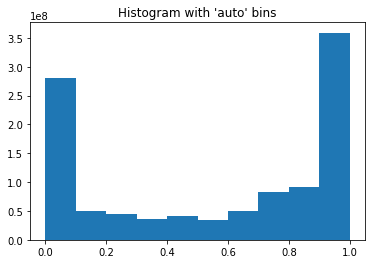

In [59]:
plt.hist(p_values, bins=10)# arguments are passed to np.histogram
plt.title("Histogram of p-values with 10 bins")
plt.show()

In [63]:
count, bins = np.histogram(p_values, 10)

In [68]:
print "Find a set of balanced classes..."
print count
print np.sum(count[:2]), np.sum(count[2:-1]), np.sum(count[-1:])
print bins

Find a set of balanced classes...
[281233430  50134726  45021608  36537099  40631026  33990867  49058979
  82307229  91348267 358907995]
331368156 378895075 358907995
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


In [74]:
'''
bin 0: [0, 0.2]
bin 1: [0.2, 0.8]
bin 2: [0.9, 1.0]
'''
new_count, new_bins = np.histogram(p_values, bins=[0.0, 0.2, 0.9, 1.0])
print new_count
print new_bins

[331368156 378895075 358907995]
[ 0.   0.2  0.9  1. ]


In [86]:
bar_bins = [str([str(new_bins[i])[:4], str(new_bins[i+1])[:4]]) for i in range(len(new_bins)-1)]
print bar_bins

["['0.0', '0.2']", "['0.2', '0.9']", "['0.9', '1.0']"]


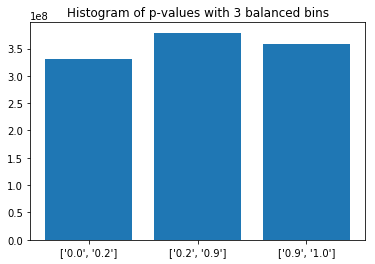

In [87]:
labels = ['Bin1', 'Bin2', 'Bin3']
plt.bar(bar_bins, new_count, width=0.8, label=labels)
plt.title("Histogram of p-values with 3 balanced bins")
plt.show()